In [1]:
import os
import gzip
import sys
import pyBigWig
import numpy as np

In [2]:
bedPath = "data/pho4/1000_around_summits.bed.gz"

In [3]:
bigWigs = (pyBigWig.open("data/pho4/pos_strand.bw"),
           pyBigWig.open("data/pho4/neg_strand.bw"))

In [4]:
fastapath = "sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [5]:
chrm_sizes = {}
for chrm in GenomeDict.keys():
    chrm_sizes[chrm]=len(GenomeDict[chrm])

In [6]:
totalNumPeaks = 6086

In [7]:
import re

width = 250
posFootprint = {}
negFootprint = {}
numInstances = {}
peaksContainingMotif = {}
motifs = ["CACGTG", "CATGTG", "CACATG"]
for motif in motifs:
    numInstances[motif] = 0
    peaksContainingMotif[motif] = 0
    posFootprint[motif] = np.zeros((2*width,))
    negFootprint[motif] = np.zeros((2*width,))
with gzip.open(bedPath,'rt') as f:
    for line in f:
        chrm, start, end, _ = line.rstrip().split('\t')
        sequence = GenomeDict[chrm][int(start):int(end)].upper()
        for motif in motifs:
            matches = [int(start)+m.start()+3 for m in re.finditer(motif, sequence)]
            if len(matches) != 0:
                peaksContainingMotif[motif] += 1
            for coord in matches:
                if coord-width<0 or coord+width>=chrm_sizes[chrm]:
                    continue
                numInstances[motif] += 1
                posvals = np.array(bigWigs[0].values(chrm, coord-width, coord+width))
                where_are_NaNs = np.isnan(posvals)
                posvals[where_are_NaNs] = 0.0
                posFootprint[motif] += posvals
                negvals = np.array(bigWigs[1].values(chrm, coord-width, coord+width))
                where_are_NaNs = np.isnan(negvals)
                negvals[where_are_NaNs] = 0.0
                negFootprint[motif] += negvals
for motif in motifs:
    print(motif)
    posFootprint[motif] = posFootprint[motif]/float(numInstances[motif])
    negFootprint[motif] = negFootprint[motif]/float(numInstances[motif])
    print("number of peaks with motifs: ", peaksContainingMotif[motif])
    print("total number of peaks: ", totalNumPeaks)
    print("fraction of peaks with motifs: ", peaksContainingMotif[motif]/float(totalNumPeaks))
    print("total number of motif instances: ", numInstances[motif])

CACGTG
number of peaks with motifs:  1763
total number of peaks:  6086
fraction of peaks with motifs:  0.28968123562274073
total number of motif instances:  1952
CATGTG
number of peaks with motifs:  1257
total number of peaks:  6086
fraction of peaks with motifs:  0.20653959907985542
total number of motif instances:  1411
CACATG
number of peaks with motifs:  1235
total number of peaks:  6086
fraction of peaks with motifs:  0.20292474531712126
total number of motif instances:  1399


CACGTG


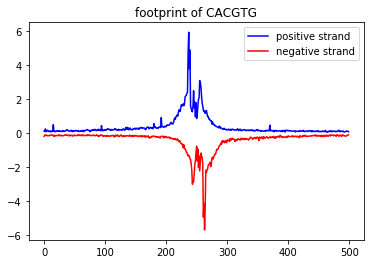

CATGTG


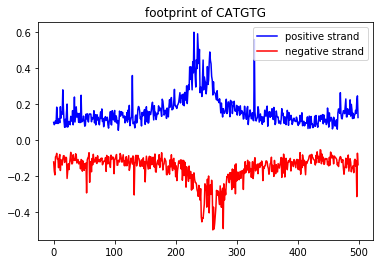

CACATG


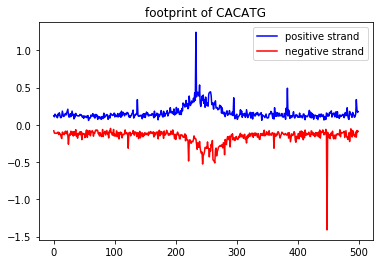

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

for motif in motifs:
    print(motif)
    t = range(2*width)
    plt.plot(t, posFootprint[motif], 'b', label='positive strand') 
    plt.plot(t, negFootprint[motif], 'r', label='negative strand')
    plt.title(r'footprint of '+motif)
    plt.legend(loc='upper right')
    plt.show()

In [9]:
interesting_regions = []
nomotif_posFootprint = np.zeros((2*width,))
nomotif_negFootprint = np.zeros((2*width,))
fout = open("interesting_regions.bed", 'w+')
with gzip.open("data/pho4/test_1000_around_summits.bed.gz",'rt') as f:
    for line in f:
        chrm, start, end, _ = line.rstrip().split('\t')
        sequence = GenomeDict[chrm][int(start):int(end)].upper()
        if "CACGTG" in sequence:
            continue
        elif "CATGTG" in sequence:
            continue
        elif "CACATG" in sequence:
            continue
        else:
            fout.write(chrm+"\t"+start+"\t"+end+"\t"+".\n")
            interesting_regions.append((chrm, int(start)+width, int(end)-width))
            posvals = np.array(bigWigs[0].values(chrm, int(start)+width, int(end)-width))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            nomotif_posFootprint += posvals
            negvals = np.array(bigWigs[1].values(chrm, int(start)+width, int(end)-width))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            nomotif_negFootprint += negvals
fout.close()

In [10]:
!head interesting_regions.bed

chrX	23372	24372	.
chrX	33031	34031	.
chrX	56591	57591	.
chrX	69477	70477	.
chrX	69509	70509	.
chrX	70832	71832	.
chrX	80638	81638	.
chrX	80673	81673	.
chrX	106961	107961	.
chrX	119336	120336	.


In [11]:
!gzip interesting_regions.bed

In [12]:
len(interesting_regions)

263

In [13]:
nomotif_posFootprint = nomotif_posFootprint/float(len(interesting_regions))
nomotif_negFootprint = nomotif_negFootprint/float(len(interesting_regions))

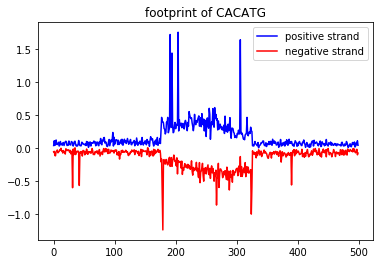

In [14]:
t = range(2*width)
plt.plot(t, nomotif_posFootprint, 'b', label='positive strand') 
plt.plot(t, nomotif_negFootprint, 'r', label='negative strand')
plt.title(r'footprint of '+motif)
plt.legend(loc='upper right')
plt.show()

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0, 3"

In [16]:
import numpy as np
import gzip
import keras
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [17]:
from keras.models import load_model
from keras.utils import CustomObjectScope

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model('pho4_model.h5')







Instructions for updating:
Use `tf.cast` instead.


Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer


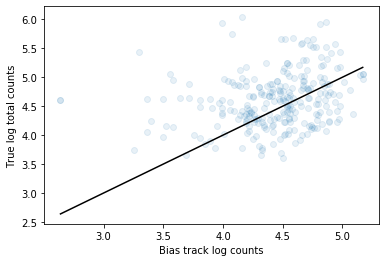

SpearmanrResult(correlation=0.26676861094648735, pvalue=1.1578116964852246e-05)


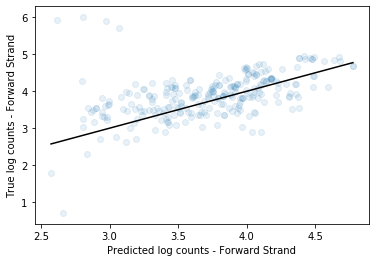

SpearmanrResult(correlation=0.5546608194192166, pvalue=1.2827788685881898e-22)


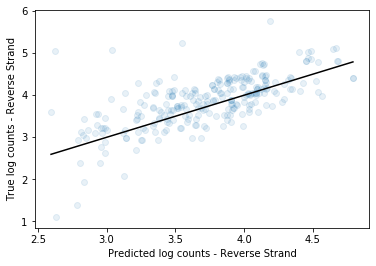

SpearmanrResult(correlation=0.690670305637105, pvalue=1.299723945060924e-38)


In [18]:
o_test_preds_logcount = []
o_test_biastrack_logcount = []
o_test_biastrack_profile = []
o_test_seqs = []
o_test_preds_profile = []
o_test_labels_logcount = []
o_test_labels_profile = []

seq_len = 546
out_pred_len = 200

pos_neg_smooth_log_counts =\
  coordstovals.bigwig.PosAndNegSmoothWindowCollapsedLogCounts(
        pos_strand_bigwig_path="data/ctl/control_pos_strand.bw",
        neg_strand_bigwig_path="data/ctl/control_neg_strand.bw",
        counts_mode_name="control_logcount",
        profile_mode_name="control_profile",
        center_size_to_use=out_pred_len,
        smoothing_windows=[1,50])

inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="sacCer3.genome.fa",
        mode_name="sequence",
        center_size_to_use=seq_len),
      pos_neg_smooth_log_counts])

targets_coordstovals = coordstovals.bigwig.PosAndNegSeparateLogCounts(
    pos_strand_bigwig_path="data/pho4/pos_strand.bw",
    neg_strand_bigwig_path="data/pho4/neg_strand.bw",
    counts_mode_name="task0_logcount",
    profile_mode_name="task0_profile",
    center_size_to_use=out_pred_len)

keras_test_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="interesting_regions.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

orig_seqs = []

for batch_idx in range(len(keras_test_batch_generator)):
    batch_inputs, batch_labels = keras_test_batch_generator[batch_idx]
    o_test_seqs.append(batch_inputs['sequence']) 
    o_test_biastrack_logcount.append(batch_inputs['control_logcount'])
    o_test_biastrack_profile.append(batch_inputs['control_profile'])
    
    #orig_seqs.append(convertToString(batch_inputs['sequence']))
    
    test_preds = model.predict(batch_inputs)
    o_test_preds_logcount.append(test_preds[0])
    o_test_preds_profile.append(test_preds[1])
    o_test_labels_logcount.append(batch_labels['task0_logcount'])
    o_test_labels_profile.append(batch_labels['task0_profile'])
o_test_biastrack_logcount = np.concatenate(o_test_biastrack_logcount, axis=0)
o_test_biastrack_profile = np.concatenate(o_test_biastrack_profile,axis=0)
o_test_seqs = np.concatenate(o_test_seqs,axis=0)
o_test_preds_logcount = np.concatenate(o_test_preds_logcount, axis=0)
o_test_preds_profile = np.concatenate(o_test_preds_profile, axis=0)
o_test_labels_logcount = np.concatenate(o_test_labels_logcount, axis=0)
o_test_labels_profile = np.concatenate(o_test_labels_profile, axis=0)

from matplotlib import pyplot as plt
from scipy.stats import spearmanr

o_test_labels_logtotalcount = np.log(np.sum(np.exp(o_test_labels_logcount) - 1,axis=-1) + 1)

plt.scatter(o_test_biastrack_logcount, o_test_labels_logtotalcount, alpha=0.1)
plt.xlabel("Bias track log counts")
plt.ylabel("True log total counts")
plt.plot([np.min(o_test_biastrack_logcount), np.max(o_test_biastrack_logcount)],
         [np.min(o_test_biastrack_logcount), np.max(o_test_biastrack_logcount)],
         color="black")
plt.show()
print(spearmanr(o_test_biastrack_logcount, o_test_labels_logtotalcount))


#do a scatterplot of total count predictions
plt.scatter(o_test_preds_logcount[:,0], o_test_labels_logcount[:,0], alpha=0.1)
plt.xlabel("Predicted log counts - Forward Strand")
plt.ylabel("True log counts - Forward Strand")
plt.plot([np.min(o_test_preds_logcount[:,0]), np.max(o_test_preds_logcount[:,0])],
         [np.min(o_test_preds_logcount[:,0]), np.max(o_test_preds_logcount[:,0])],
         color="black")
plt.show()
print(spearmanr(o_test_preds_logcount[:,0], o_test_labels_logcount[:,0]))

plt.scatter(o_test_preds_logcount[:,1], o_test_labels_logcount[:,1], alpha=0.1)
plt.xlabel("Predicted log counts - Reverse Strand")
plt.ylabel("True log counts - Reverse Strand")
plt.plot([np.min(o_test_preds_logcount[:,1]), np.max(o_test_preds_logcount[:,1])],
         [np.min(o_test_preds_logcount[:,1]), np.max(o_test_preds_logcount[:,1])],
         color="black")
plt.show()
print(spearmanr(o_test_preds_logcount[:,1], o_test_labels_logcount[:,1]))

In [19]:
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[1]],
     tf.reduce_sum(model.outputs[0],axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

#See Google slide deck for explanations
#We meannorm as per section titled "Adjustments for Softmax Layers"
# in the DeepLIFT paper
meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
#'stop_gradient' will prevent importance from being propagated through
# this operation; we do this because we just want to treat the post-softmax
# probabilities as 'weights' on the different logits, without having the
# network explain how the probabilities themselves were derived
#Could be worth contrasting explanations derived with and without stop_gradient
# enabled...
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(stopgrad_meannormed_logits,axis=1)
#Weight the logits according to the softmax probabilities, take the sum for each
# example. This mirrors what was done for the bpnet paper.
weightedsum_meannormed_logits = tf.reduce_sum(softmax_out*meannormed_logits,
                                              axis=(1,2))
profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[2]],
     weightedsum_meannormed_logits),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

In [20]:
#The shap scores
post_counts_hypimps,_ = profile_model_counts_explainer.shap_values(
    [o_test_seqs, np.zeros((len(o_test_seqs), 1))],
    progress_message=10)
post_profile_hypimps,_ = profile_model_profile_explainer.shap_values(
    [o_test_seqs, np.zeros((len(o_test_seqs), 200, 2))],
    progress_message=10)

post_counts_actualimps = post_counts_hypimps*o_test_seqs
post_profile_actualimps = post_profile_hypimps*o_test_seqs

Done 0 examples of 263
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done 10 examples of 263
Done 20 examples of 263
Done 30 examples of 263
Done 40 examples of 263
Done 50 examples of 263
Done 60 examples of 263
Done 70 examples of 263
Done 80 examples of 263
Done 90 examples of 263
Done 100 examples of 263
Done 110 examples of 263
Done 120 examples of 263
Done 130 examples of 263
Done 140 examples of 263
Done 150 examples of 263
Done 160 examples of 263
Done 170 examples of 263
Done 180 examples of 263
Done 190 examples of 263
Done 200 examples of 263
Done 210 examples of 263
Done 220 examples of 263
Done 230 examples of 263
Done 240 examples of 263
Done 250 examples of 263
Done 260 examples of 263
Done 0 examples of 263
Done 10 examples of 263
Done 20 examples of 263
Done 30 examples of 263
Done 40 examples of 263
Done 50 examples of 263
Done 60 examples of 263
Done 70 examples of 263
Done 80 examples of 263
Done 90 examples of 263
Don

idx 98
Counts [409.  10.]
Predcounts [15.523863 15.597773]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


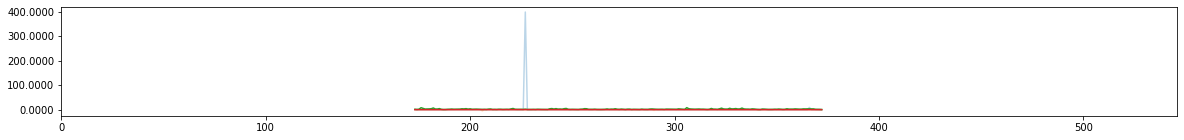

counts imp


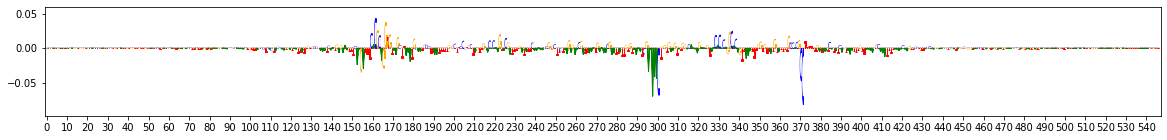

profile imp


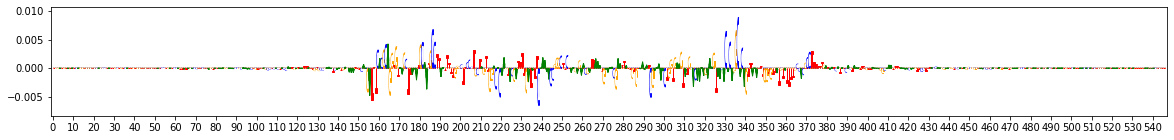

idx 236
Counts [363.  24.]
Predcounts [18.624199 18.870876]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


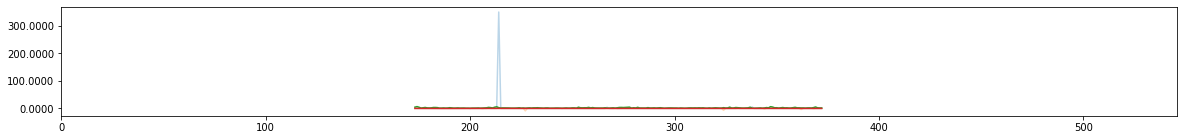

counts imp


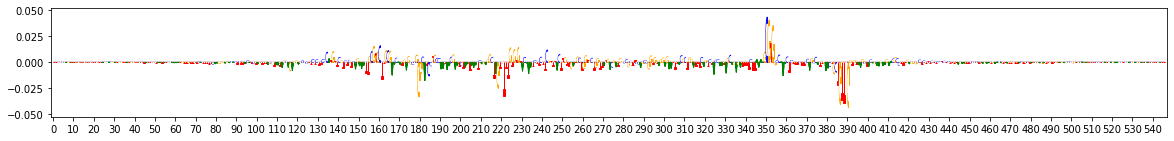

profile imp


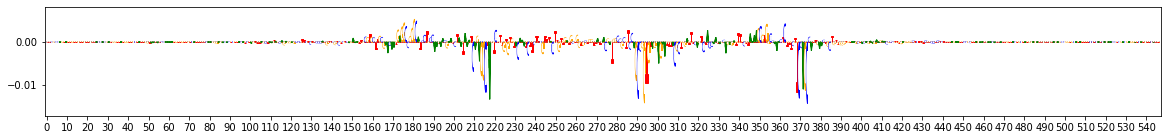

idx 47
Counts [377.   2.]
Predcounts [12.742942 12.924625]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


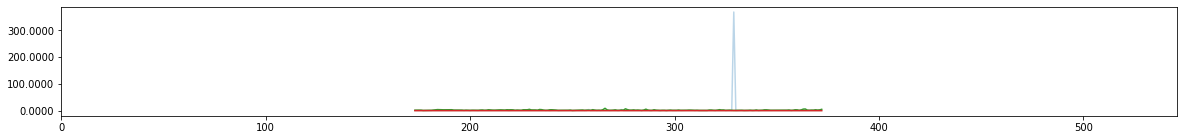

counts imp


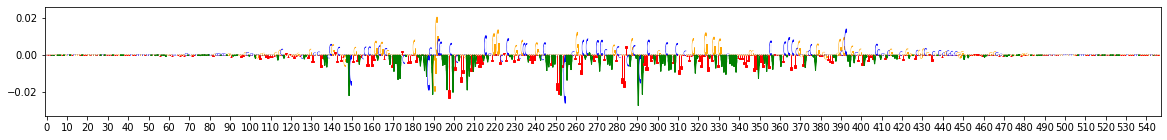

profile imp


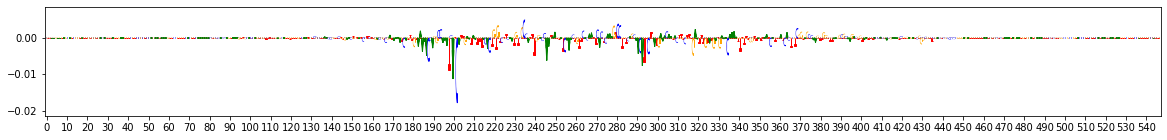

idx 174
Counts [ 50. 319.]
Predcounts [76.91478 65.18365]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


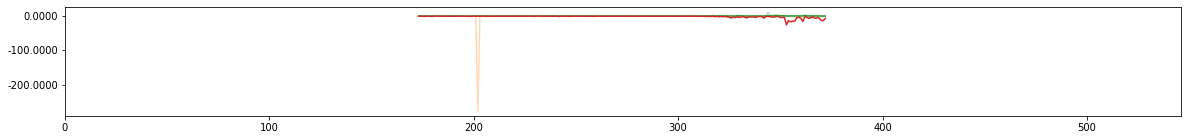

counts imp


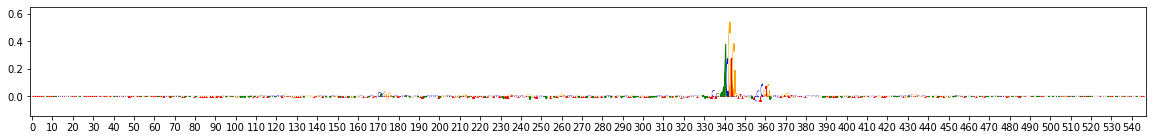

profile imp


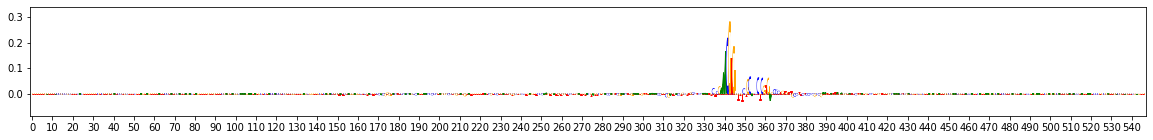

idx 97
Counts [305.  10.]
Predcounts [20.58376  18.192924]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


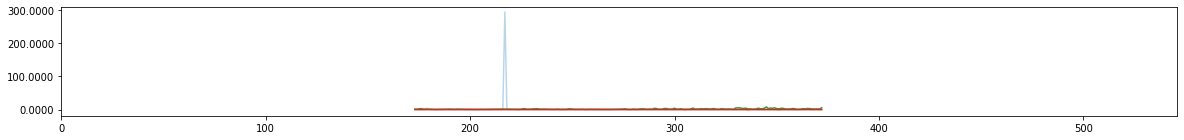

counts imp


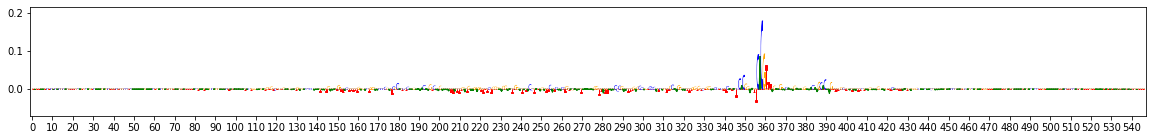

profile imp


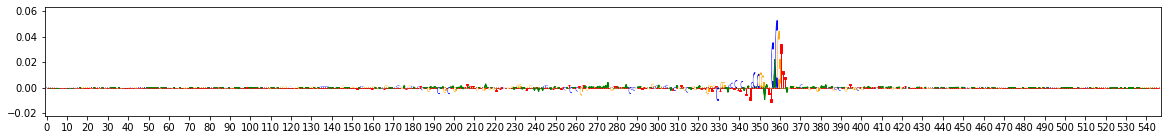

idx 136
Counts [140. 152.]
Predcounts [81.77197 80.24235]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


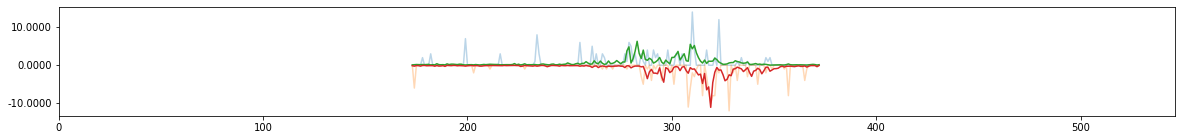

counts imp


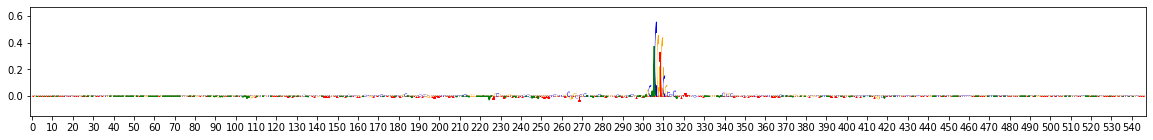

profile imp


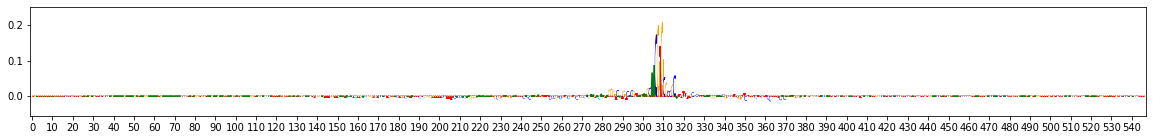

idx 202
Counts [134. 154.]
Predcounts [85.651436 87.675354]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


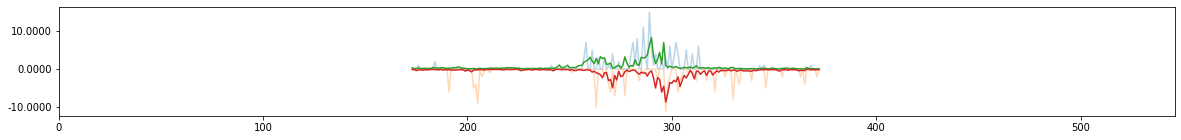

counts imp


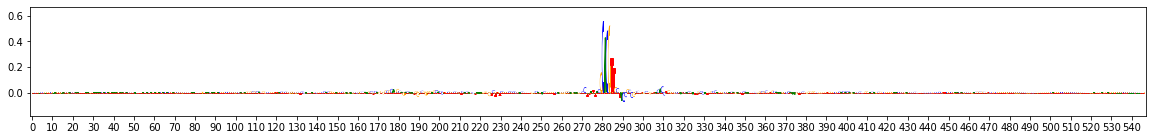

profile imp


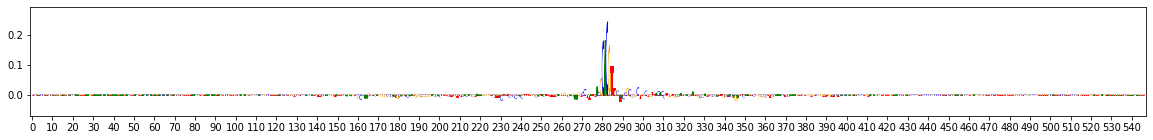

idx 80
Counts [122. 165.]
Predcounts [106.44884 105.46149]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


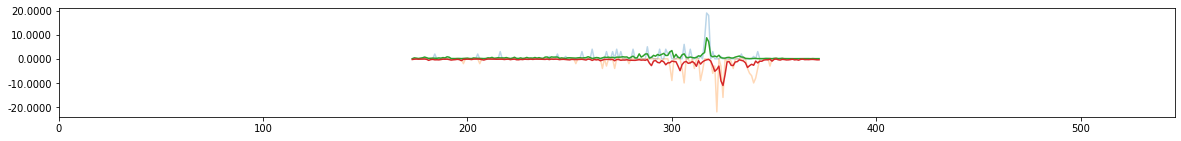

counts imp


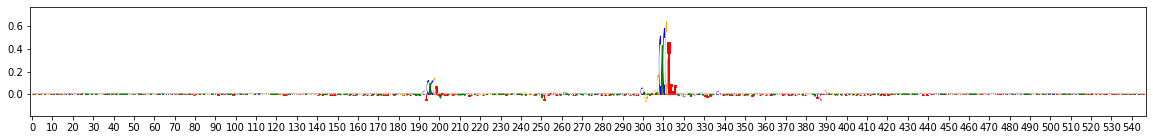

profile imp


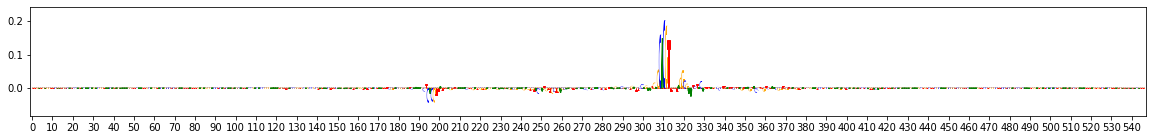

idx 81
Counts [123. 164.]
Predcounts [ 94.792816 103.02323 ]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


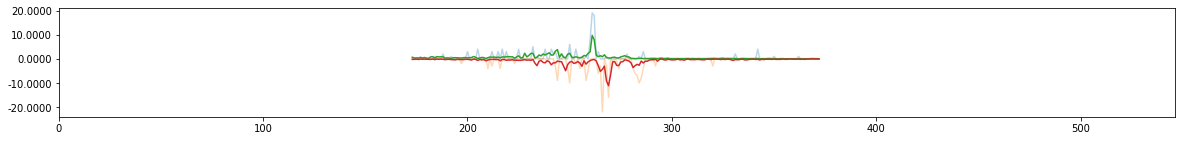

counts imp


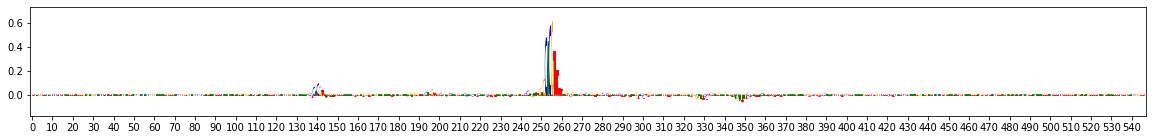

profile imp


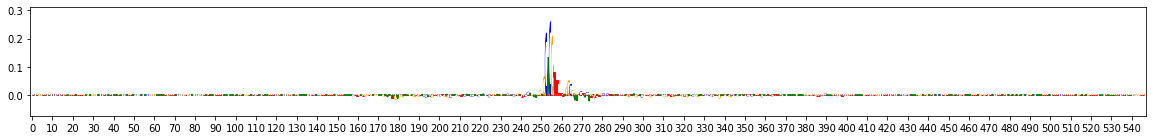

idx 137
Counts [131. 151.]
Predcounts [82.4627  85.75744]
oneovertemp 1.0
(200, 2)
Pred profile shape (200, 2)


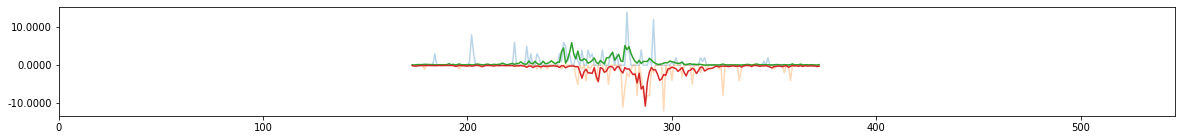

counts imp


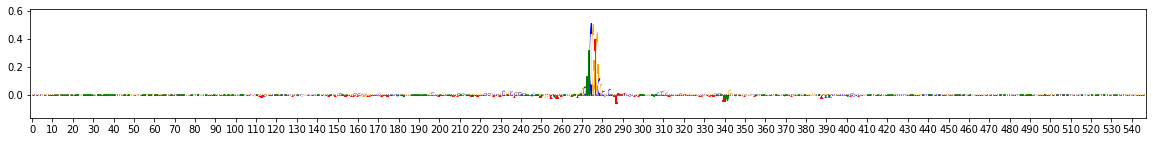

profile imp


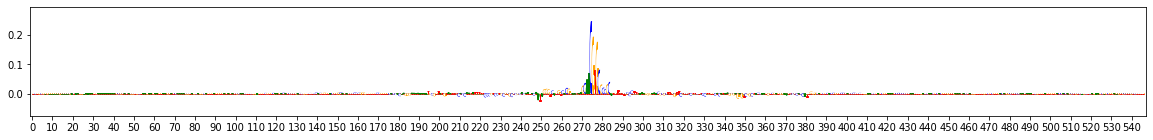

In [21]:
from deeplift.visualization import viz_sequence
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

sorted_test_indices = [x[0] for x in 
                       sorted(enumerate(o_test_labels_logtotalcount),
                              key=lambda x: -x[1])]

def smooth(vals):
  return np.convolve(vals, np.ones(1,)/1, mode='same')

for idx in sorted_test_indices[:10]: 
    true_profile = o_test_labels_profile[idx] 
    print("idx",idx)
    print("Counts",np.sum(true_profile,axis=0))
    print("Predcounts",np.exp(o_test_preds_logcount[idx])-1)
    
    for oneovertemp in [1.0]:
        print("oneovertemp",oneovertemp)
        print(o_test_labels_profile[idx].shape)
        print("Pred profile shape", o_test_preds_profile[idx].shape)
        pred_profile = (np.sum(o_test_labels_profile[idx], axis=0)[None,:] #total counts
                      *(np.exp(o_test_preds_profile[idx]*oneovertemp)/
                        np.sum(np.exp(o_test_preds_profile[idx]*oneovertemp),axis=0)[None,:]) )   
        plt.figure(figsize=(20,2))

        seq_len = 546
        out_pred_len = 200
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        plt.plot(np.arange(out_pred_len)+left_flank, smooth(true_profile[:,0]), alpha=0.3)
        plt.plot(np.arange(out_pred_len)+left_flank, -smooth(true_profile[:,1]), alpha=0.3)
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(0,seq_len)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        plt.show()

    print("counts imp")
    viz_sequence.plot_weights(post_counts_actualimps[idx],
                            subticks_frequency=10)
    print("profile imp")
    viz_sequence.plot_weights(post_profile_actualimps[idx],
                            subticks_frequency=10)